In [46]:
BUCKET = 'innovationday-467664929633'
OVERRIDE_PATH = None
DATA_LOCATION = 's3a://{}'.format(BUCKET)

In [47]:
import numpy as np
import pandas as pd
from time import time
from io import StringIO

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta
import sagemaker_pyspark, boto3
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, DoubleType, StringType, TimestampType, StructType, StructField
import json
from IPython.display import display # Allows the use of display() for displaying DataFrames


from sagemaker import get_execution_role
role = get_execution_role()

In [48]:
pd.set_option('display.max_columns', 500)
region = boto3.Session().region_name
classpath = ":".join(sagemaker_pyspark.classpath_jars())
spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath).getOrCreate()

In [49]:
#cbbc_daily_summary.csv
cbbc_daily_summary = pd.read_csv(f'{DATA_LOCATION}/cbbc_daily_summary.csv')
display(cbbc_daily_summary.head())
cbbc_daily_summary.info()

,date,sym,CBBCCode,CBBCName,TradeDate,CBBCsBought,AveragePriceBought,CBBCsSold,AveragePriceSold,Outstanding,OutstandingPct,TotalIssueSize,TradingCurrency,DayHigh,DayLow,ClosingPrice,Volume,Turnover,Issuer,Underlying,BullBear,CBBCType,CBBCCategory,ListingDate,LastTradingDate,MaturityDate,MCE,Strike_CallCurrency,StrikeLevel,CallLevel,EntRatio,DelistingDate,ldt
0,2016-01-04,60018.hk,60018,CS#HSI RP1601Y,2016-01-04,0.0,0.000000,-20000.0,-0.225500,90490000.0,45.25,200000000.0,HKD,0.237,0.223,0.248,120000,28210,CS,HSI,Bear,Standard,R,2015-08-25,2016-01-27,2016-01-28,N,-,23800.0,23600.0,10000,2016-01-29,2019-03-11D19:21:06.181120000
1,2016-01-04,60023.hk,60023,CS#HSI RP1602C,2016-01-04,830000.0,0.183771,-510000.0,-0.197137,130960000.0,65.48,200000000.0,HKD,0.205,0.164,0.199,7750000,1478070,CS,HSI,Bear,Standard,R,2015-08-25,2016-02-25,2016-02-26,N,-,23725.0,23475.0,12000,2016-02-29,2019-03-11D19:21:06.181120000
2,2016-01-04,60045.hk,60045,EA#TENCTRC1610A,2016-01-04,0.0,0.000000,0.0,0.000000,0.0,0.00,40000000.0,HKD,0.000,0.000,NaN,0,0,EA,00700,Bull,Standard,R,2015-10-02,NaN,2016-10-26,N,HKD,115.0,118.0,100,NaN,2019-03-11D19:21:06.181120000
3,2016-01-04,60046.hk,60046,SG#HSI RP1602Z,2016-01-04,10000.0,0.249000,-280000.0,-0.246714,290000.0,0.15,200000000.0,HKD,0.249,0.246,0.260,290000,71570,SG,HSI,Bear,Standard,R,2015-08-25,2016-02-25,2016-02-26,N,-,23788.0,23688.0,10000,2016-02-29,2019-03-11D19:21:06.181120000
4,2016-01-04,60051.hk,60051,SG#HSI RP1602A,2016-01-04,2670000.0,0.227225,-1620000.0,-0.219426,1210000.0,0.61,200000000.0,HKD,0.243,0.200,0.240,4290000,962160,SG,HSI,Bear,Standard,R,2015-08-25,2016-02-25,2016-02-26,N,-,23588.0,23488.0,10000,2016-02-29,2019-03-11D19:21:06.181120000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152111 entries, 0 to 1152110
Data columns (total 33 columns):
date                   1152111 non-null object
sym                    1152111 non-null object
CBBCCode               1152111 non-null int64
CBBCName               1152111 non-null object
TradeDate              1152111 non-null object
CBBCsBought            1151871 non-null float64
AveragePriceBought     1151871 non-null float64
CBBCsSold              1151871 non-null float64
AveragePriceSold       1151871 non-null float64
Outstanding            1151871 non-null float64
OutstandingPct         1151871 non-null float64
TotalIssueSize         1151871 non-null float64
TradingCurrency        1152111 non-null object
DayHigh                1152111 non-null float64
DayLow                 1152111 non-null float64
ClosingPrice           1067680 non-null float64
Volume                 1152111 non-null int64
Turnover               1152111 non-null int64
Issuer                 1152111 non

In [53]:
# add few column
data = cbbc_daily_summary.copy()

# add net sales column
data['NetSales'] = data.apply(lambda row: -1 * ((row['CBBCsBought'] + row['CBBCsSold']) * row['ClosingPrice']) / row['EntRatio'], axis = 1)

#add the days left from the maturity date and the days past the listing date columns
data['DaysPastListingDate'] = (pd.to_datetime(data['TradeDate']) - pd.to_datetime(data['ListingDate'])).dt.days
data['DaysFromMaturityDate'] = (pd.to_datetime(data['MaturityDate']) - pd.to_datetime(data['TradeDate'])).dt.days
data['MaturityDaysFromIssuance'] = (pd.to_datetime(data['MaturityDate']) - pd.to_datetime(data['ListingDate'])).dt.days

# spread
data['Spread'] = data['AveragePriceSold'] - data['AveragePriceBought']
data['Spread'] = data['Spread'].abs()

# call level relative to strike level
data['callVsStrike'] = (data['CallLevel'] - data['StrikeLevel']) / data['StrikeLevel']
data['callVsStrike'] = data['callVsStrike'].abs()

# print
display(data.head())

,date,sym,CBBCCode,CBBCName,TradeDate,CBBCsBought,AveragePriceBought,CBBCsSold,AveragePriceSold,Outstanding,OutstandingPct,TotalIssueSize,TradingCurrency,DayHigh,DayLow,ClosingPrice,Volume,Turnover,Issuer,Underlying,BullBear,CBBCType,CBBCCategory,ListingDate,LastTradingDate,MaturityDate,MCE,Strike_CallCurrency,StrikeLevel,CallLevel,EntRatio,DelistingDate,ldt,NetSales,DaysPastListingDate,DaysFromMaturityDate,MaturityDaysFromIssuance,Spread,callVsStrike
0,2016-01-04,60018.hk,60018,CS#HSI RP1601Y,2016-01-04,0.0,0.000000,-20000.0,-0.225500,90490000.0,45.25,200000000.0,HKD,0.237,0.223,0.248,120000,28210,CS,HSI,Bear,Standard,R,2015-08-25,2016-01-27,2016-01-28,N,-,23800.0,23600.0,10000,2016-01-29,2019-03-11D19:21:06.181120000,0.496000,132,24,156,0.225500,0.008403
1,2016-01-04,60023.hk,60023,CS#HSI RP1602C,2016-01-04,830000.0,0.183771,-510000.0,-0.197137,130960000.0,65.48,200000000.0,HKD,0.205,0.164,0.199,7750000,1478070,CS,HSI,Bear,Standard,R,2015-08-25,2016-02-25,2016-02-26,N,-,23725.0,23475.0,12000,2016-02-29,2019-03-11D19:21:06.181120000,-5.306667,132,53,185,0.380908,0.010537
2,2016-01-04,60045.hk,60045,EA#TENCTRC1610A,2016-01-04,0.0,0.000000,0.0,0.000000,0.0,0.00,40000000.0,HKD,0.000,0.000,NaN,0,0,EA,00700,Bull,Standard,R,2015-10-02,NaN,2016-10-26,N,HKD,115.0,118.0,100,NaN,2019-03-11D19:21:06.181120000,NaN,94,296,390,0.000000,0.026087
3,2016-01-04,60046.hk,60046,SG#HSI RP1602Z,2016-01-04,10000.0,0.249000,-280000.0,-0.246714,290000.0,0.15,200000000.0,HKD,0.249,0.246,0.260,290000,71570,SG,HSI,Bear,Standard,R,2015-08-25,2016-02-25,2016-02-26,N,-,23788.0,23688.0,10000,2016-02-29,2019-03-11D19:21:06.181120000,7.020000,132,53,185,0.495714,0.004204
4,2016-01-04,60051.hk,60051,SG#HSI RP1602A,2016-01-04,2670000.0,0.227225,-1620000.0,-0.219426,1210000.0,0.61,200000000.0,HKD,0.243,0.200,0.240,4290000,962160,SG,HSI,Bear,Standard,R,2015-08-25,2016-02-25,2016-02-26,N,-,23588.0,23488.0,10000,2016-02-29,2019-03-11D19:21:06.181120000,-25.200000,132,53,185,0.446651,0.004239


In [55]:
# do the aggregations to get the net sales across all the products for their lifetime
data = data.groupby(
    ['CBBCCode'], as_index=False
).agg(
    {
        'NetSales': sum,
        'TotalIssueSize': 'first',
        'Issuer': 'first',
        'Underlying': 'first',
        'BullBear': 'first',
        'CBBCCategory': 'first',
        'StrikeLevel': 'first',
        'callVsStrike': 'first',
        'Spread': 'first',
        'EntRatio': 'first',
        'MaturityDaysFromIssuance': 'first'
    }
)

# print the data
display(data.head())

,CBBCCode,NetSales,TotalIssueSize,Issuer,Underlying,BullBear,CBBCCategory,StrikeLevel,callVsStrike,Spread,EntRatio,MaturityDaysFromIssuance
0,57000,-148.363000,200000000.0,GS,HSI,Bull,R,30800.00,0.003247,0.113613,10000,640
1,57001,-3225.808000,200000000.0,GS,HSI,Bull,R,31015.00,0.003224,0.078728,10000,640
2,57002,-977.464000,200000000.0,GS,HSI,Bear,R,32300.00,0.003096,0.213067,10000,213
3,57003,8593.038333,100000000.0,GS,00700,Bull,R,444.98,0.004495,0.240313,100,113
4,57004,2068.300000,100000000.0,GS,00700,Bull,R,443.08,0.004514,0.253548,100,114


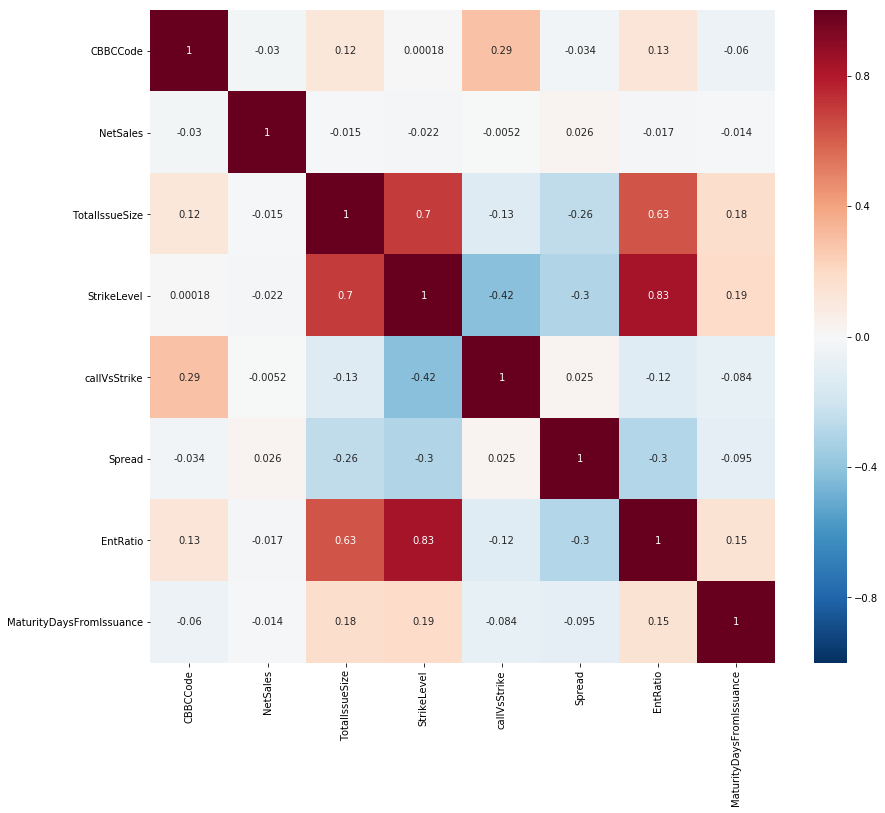

In [56]:
correlation = data.corr()
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

# so there is no direct correlation of the internal factors on the net sales of a product over lifetime
# total issue size, strikelevel, entitlemnt ratio are correlated

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


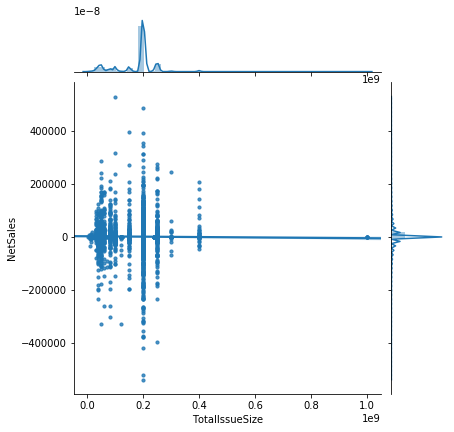

In [57]:
# Net Sales vs Total Issue Size
comparison = data[['TotalIssueSize', 'NetSales']]

#Initialize a joint-grid with the dataframe, using seaborn library
gridA = sns.JointGrid(x="TotalIssueSize", y="NetSales", data=comparison)

#Draws a regression plot in the grid 
gridA = gridA.plot_joint(sns.regplot, scatter_kws={"s": 10})

#Draws a distribution plot in the same grid
gridA = gridA.plot_marginals(sns.distplot)

# From below graph, the conclusion is issue size of 2*10^8, 2.5*10^8 leads to max net sales, although also at this level there can be less sales as well. Therefore other factors will come into play.

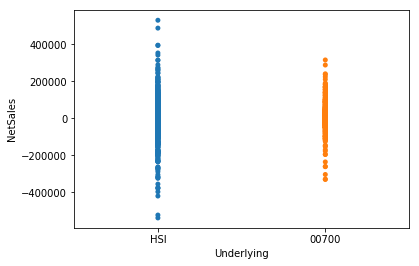

In [58]:
# Comparison
comparison = data[['Underlying', 'NetSales']]

sns.stripplot(x="Underlying", y="NetSales", data=comparison);

# From below graph, underlying asset as hsi has much more net sales although there are more losses as well

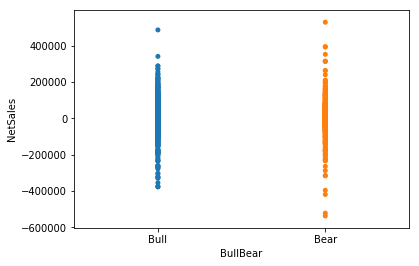

In [59]:
# Comparison
comparison = data[['BullBear', 'NetSales']]

sns.stripplot(x="BullBear", y="NetSales", data=comparison);

# From below graph, not much of overall picture with bull or bear products

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


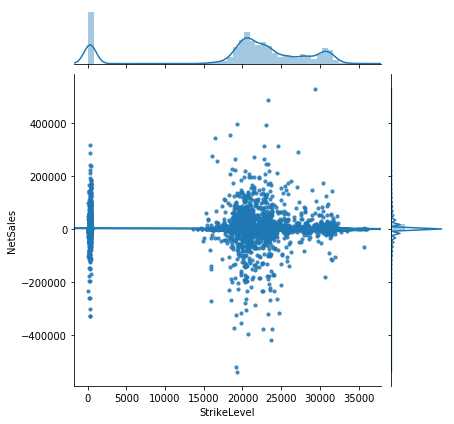

In [60]:
# Comparison
comparison = data[['StrikeLevel', 'NetSales']]

#Initialize a joint-grid with the dataframe, using seaborn library
gridA = sns.JointGrid(x="StrikeLevel", y="NetSales", data=comparison)

#Draws a regression plot in the grid 
gridA = gridA.plot_joint(sns.regplot, scatter_kws={"s": 10})

#Draws a distribution plot in the same grid
gridA = gridA.plot_marginals(sns.distplot)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


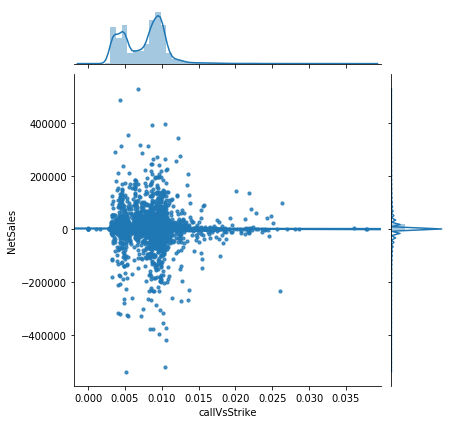

In [61]:
# Comparison
comparison = data[['callVsStrike', 'NetSales']]

#Initialize a joint-grid with the dataframe, using seaborn library
gridA = sns.JointGrid(x="callVsStrike", y="NetSales", data=comparison)

#Draws a regression plot in the grid 
gridA = gridA.plot_joint(sns.regplot, scatter_kws={"s": 10})

#Draws a distribution plot in the same grid
gridA = gridA.plot_marginals(sns.distplot)

# if call price is greater than 0.01 * 10^-7 than most chances of net positive sale
# below that both behaviours are shown by data

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


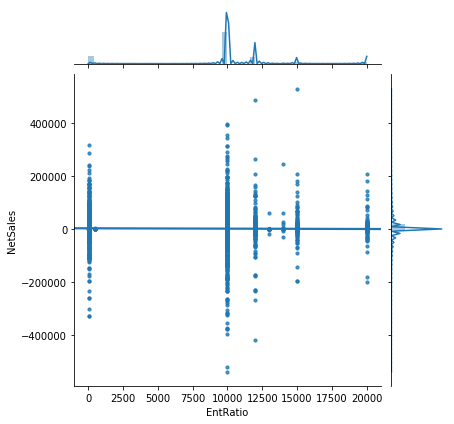

In [62]:
# Comparison
comparison = data[['EntRatio', 'NetSales']]

#Initialize a joint-grid with the dataframe, using seaborn library
gridA = sns.JointGrid(x="EntRatio", y="NetSales", data=comparison)

#Draws a regression plot in the grid 
gridA = gridA.plot_joint(sns.regplot, scatter_kws={"s": 10})

#Draws a distribution plot in the same grid
gridA = gridA.plot_marginals(sns.distplot)

#there are chances of more sales on entitlement of around 10000 or 12500

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


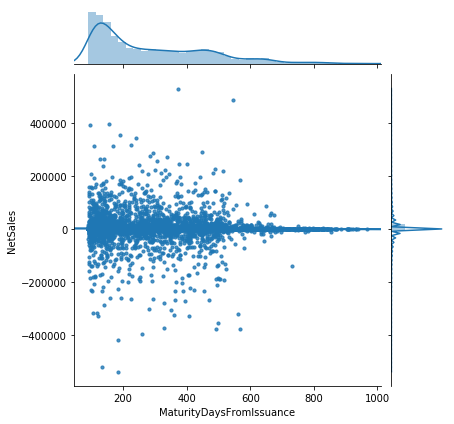

In [63]:
# Comparison
comparison = data[['MaturityDaysFromIssuance', 'NetSales']]

#Initialize a joint-grid with the dataframe, using seaborn library
gridA = sns.JointGrid(x="MaturityDaysFromIssuance", y="NetSales", data=comparison)

#Draws a regression plot in the grid 
gridA = gridA.plot_joint(sns.regplot, scatter_kws={"s": 10})

#Draws a distribution plot in the same grid
gridA = gridA.plot_marginals(sns.distplot)

# Nothing much
# chances of more net sale decreases if the maturity period increases beyond 600 days